In [1]:
pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 7.5 MB/s eta 0:00:00


In [2]:
!pip install opendatasets

# Using GANs to Turn Photos into Monet Style Pictures

In [27]:
import opendatasets as od
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [4]:
#You will need your Kaggle API info to upload these files locally in Colab
od.download("https://www.kaggle.com/competitions/gan-getting-started/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: heathermelrose
Your Kaggle Key: ··········


100%|██████████| 367M/367M [00:03<00:00, 101MB/s] 



Extracting archive ./gan-getting-started/gan-getting-started.zip to ./gan-getting-started


## 1 Brief description of the problem and data

In the "I'm Something of a Painter Myself; Using GANs to create art - will you be the next Monet?" Kaggle compeition, we have been tasked with the objective to build a GAN that generates 7000-10,000 Monet-style images.$^{1}$ On their website https://www.kaggle.com/competitions/gan-getting-started/data, Kaggle provided examples of Monet paintings and a dataset of photos to train our model. We will build a CycleGAN which will learn to take an input of a real photo and output a re-creation that looks like a painting by the famous artist Claude Monet, the father of impressionist painting.  

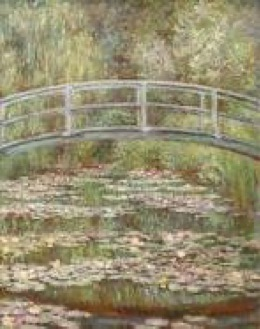

*The Water Lily Pond, Claude Monet 1899*

In [5]:
Monet_names = tf.io.gfile.glob(str('gan-getting-started/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(Monet_names))

photo_names = tf.io.gfile.glob(str('gan-getting-started/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(photo_names))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


## 2 Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

The above artwork example is one of Monet's most famous paintings and it is an excellent demonstration of Monet's art, our goal output. Kaggle provided two versions of each dataset, one jpg and the other tfrec. The Monet set contains 300 paintings and the photo set contains 7028. Choosing to work with the tfrec files for use with Keras methods.$^{2}$ We need to read in the TFRecords, files that TensorFlow uses to store binary data in sequences of byte-strings, to access these Monet files from Kaggle. The code below was learned from https://keras.io and the Kaggle Tutorial "TFRecords Basics." Let's decode the tfrecords, reshape and load our datasets,$^{3}$

In [6]:
image_size = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*image_size, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [7]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [8]:
Monet_set = load_dataset(Monet_names, labeled=True).batch(1)
photo_set = load_dataset(photo_names, labeled=True).batch(1)

example_monet = next(iter(Monet_set))
example_photo = next(iter(photo_set))

Here is an example of the data in each file: photo and Monet.

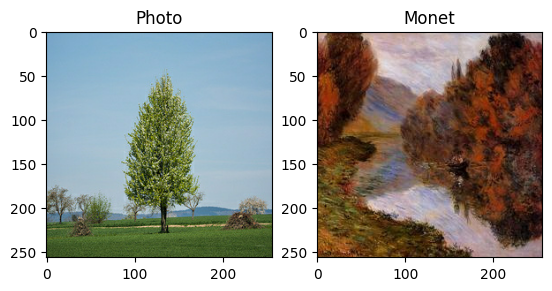

In [9]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

## 3 Model Architecture

GANs, or Generative Adversarial Networks, begin with noise and learn to create a very realistic output. In recent years this has been done with audio, visual, and text to picture. How does a computer learn to make things out of thin air? Imagine two brothers sitting at the dining room table fighting with each other day after day, year after year. The older brother, the know-it-all, is telling the younger one, "No, that's not right. This is how it works/is/happens/etc." The younger brother, who is just starting in the world gets annoyed, but takes in the feedback and comes up with a better, more accurate story. Each time the older brother is able to tell that the story is a lie and shares his all-knowing ideas with his little brother, the little brother gets better at telling a story that sounds real. Eventually, it becomes hard for the older brother to tell whether or not the little brother's story in true or not. In this metaphor, the older brother works like a GAN discriminator and the little brother like a GAN generator. This adversial, back and forth relationship helps the little brother get better and better at telling a story which may or may not be true. It is in this same manner that a GAN generator learns to create a picture out of noise, using the feedback from the discriminator. Meanwhile, the discriminator needs to decide if the input fed into it is a real or fake Monet or photo.

Inside the generator, we will take the full input image and downsample it, or reduce it in resolution while keeping the same 2D shape. Then we will upsample, or increase the spatial resolution again maintaining the 2D shape.$^{4}$ The downsample and upsample helper functions will allow us to do this multiple times.  The following code was learned from an excellent tutorial on Kaggle, "Monet CycleGAN Tutorial."$^{5}$

In [10]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

In [11]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh')

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

In [12]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)

    zero_pad1 = layers.ZeroPadding2D()(down3)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2)

    return tf.keras.Model(inputs=inp, outputs=last)

Now we want to use our generator and discrinator.

*   Monet_gen will transform a photo into a Monet-style painting
*   photo_gen will transform a Monet painting into a realistic looking photo

*   Monet_disc differentiates between the real and generated Monets
*   photo_disc differentiates between the real and generated photos





In [13]:
Monet_gen = Generator()
photo_gen = Generator()

Monet_disc = Discriminator()
photo_disc = Discriminator()

When we try running a photo through the generator without using the discriminator, the generator fails to produce a painting.

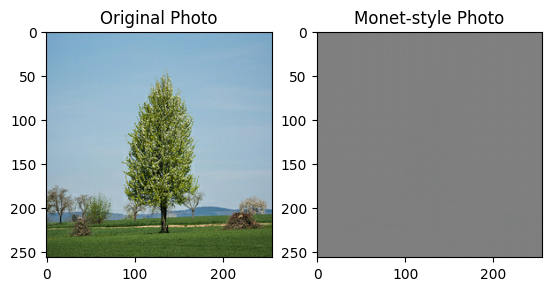

In [14]:
to_monet = Monet_gen(example_photo)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-style Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

The same is true if we start with a Monet,

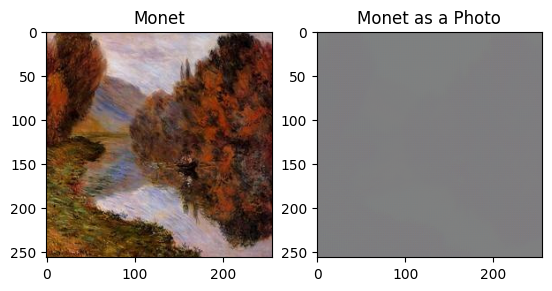

In [15]:
to_photo = photo_gen(example_monet)

plt.subplot(1, 2, 1)
plt.title("Monet")
plt.imshow(example_monet[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet as a Photo")
plt.imshow(to_photo[0] * 0.5 + 0.5)
plt.show()

This happens because the generator, without learning through back propagation from the discriminator, can only output the noise that it recieves.$^{6}$

Over the past few years, many different types of GANs have been created. CycleGAN is especially adept at image-to-image translation.$^{7}$ Examples that have been created include translating summer landscapes into winter (and vice versa), translating horses into zebras (and vice versa), and translating paintings into photographs, or like vice versa like this project.$^{8}$

In [16]:
class CycleGan(keras.Model):
    def __init__(
        self,
        Monet_gen,
        photo_gen,
        Monet_disc,
        photo_disc,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = Monet_gen
        self.p_gen = photo_gen
        self.m_disc = Monet_disc
        self.p_disc = photo_disc
        self.lambda_cycle = lambda_cycle

    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def train_step(self, batch_data):
        real_monet, real_photo = batch_data

        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))

        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

Defining the loss functions as our measuring metric,

In [17]:
def discriminator_loss(real, generated):
    full_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

    gen_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

    disc_loss = full_loss + gen_loss

    return disc_loss * 0.5

def generator_loss(generated):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image, LAMBDA):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss1

def identity_loss(real_image, same_image, LAMBDA):
    loss2 = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss2

I'm chossing to use RMSprop as the optimizer for this GAN. Conceptually, RMSprop is more straight forward than Adam. RMSprop takes the moving average in calculating gradient descent.

In [18]:
Monet_gen_opt = tf.keras.optimizers.RMSprop() #Adam(2e-4, beta_1=0.5)
photo_gen_opt = tf.keras.optimizers.RMSprop() #Adam(2e-4, beta_1=0.5)

Monet_disc_opt = tf.keras.optimizers.RMSprop() #Adam(2e-4, beta_1=0.5)
photo_disc_opt = tf.keras.optimizers.RMSprop() #Adam(2e-4, beta_1=0.5)

Now we are ready to put all of the pieces together for our CycleGAN model,

In [19]:
cycle_gan_model = CycleGan(Monet_gen, photo_gen, Monet_disc, photo_disc)

cycle_gan_model.compile(
    m_gen_optimizer = Monet_gen_opt,
    p_gen_optimizer = photo_gen_opt,
    m_disc_optimizer = Monet_disc_opt,
    p_disc_optimizer = photo_disc_opt,
    gen_loss_fn = generator_loss,
    disc_loss_fn = discriminator_loss,
    cycle_loss_fn = calc_cycle_loss,
    identity_loss_fn = identity_loss
)

## 4 Results and Analysis

Just as the little brother in our metaphor learned how to dupe his older brother over time, a GAN will learn more and get better at its job over time. The number of epochs that we run CycleGAN should have an impact on how well it produces a Monet-style painting. Let's start with 5 epochs,

In [21]:
hist1 = cycle_gan_model.fit(tf.data.Dataset.zip((Monet_set, photo_set)),epochs=5)

Epoch 1/5
300/300 [==============================] - 134s 447ms/step - monet_gen_loss: 3.4054 - photo_gen_loss: 3.3717 - monet_disc_loss: 0.6433 - photo_disc_loss: 0.6592
Epoch 2/5
300/300 [==============================] - 134s 446ms/step - monet_gen_loss: 3.0974 - photo_gen_loss: 3.0705 - monet_disc_loss: 0.6366 - photo_disc_loss: 0.6554
Epoch 3/5
300/300 [==============================] - 134s 446ms/step - monet_gen_loss: 2.9376 - photo_gen_loss: 2.9261 - monet_disc_loss: 0.6323 - photo_disc_loss: 0.6453
Epoch 4/5
300/300 [==============================] - 135s 449ms/step - monet_gen_loss: 2.8358 - photo_gen_loss: 2.8347 - monet_disc_loss: 0.6269 - photo_disc_loss: 0.6367
Epoch 5/5
300/300 [==============================] - 134s 448ms/step - monet_gen_loss: 2.7680 - photo_gen_loss: 2.7579 - monet_disc_loss: 0.6261 - photo_disc_loss: 0.6356


The result of running 5 epochs is,

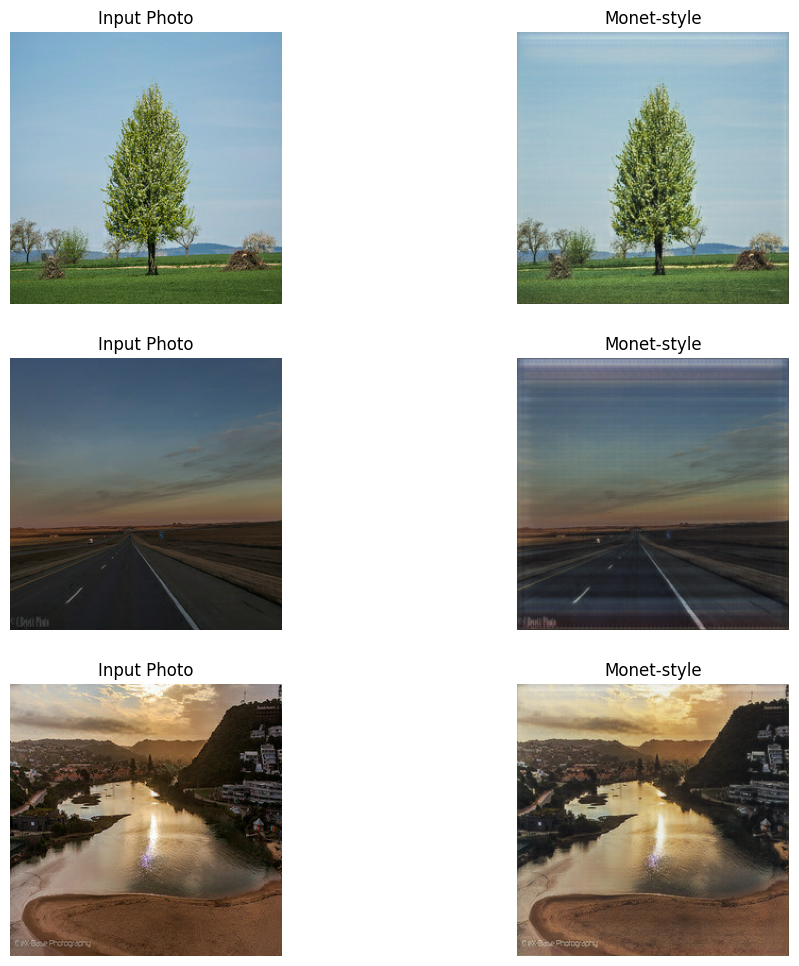

In [22]:
_, ax = plt.subplots(3, 2, figsize=(12, 12))
for i, img in enumerate(photo_set.take(3)):
    prediction = Monet_gen(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-style")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

Visually, we can see that five epochs were just enough to show a small change in the photos. Let's run this exact same GAN for longer, 15 epochs,

In [23]:
hist2 = cycle_gan_model.fit(tf.data.Dataset.zip((Monet_set, photo_set)),epochs=15)

Epoch 1/15
300/300 [==============================] - 133s 444ms/step - monet_gen_loss: 2.7109 - photo_gen_loss: 2.6981 - monet_disc_loss: 0.6238 - photo_disc_loss: 0.6309
Epoch 2/15
300/300 [==============================] - 134s 445ms/step - monet_gen_loss: 2.6764 - photo_gen_loss: 2.6596 - monet_disc_loss: 0.6227 - photo_disc_loss: 0.6294
Epoch 3/15
300/300 [==============================] - 134s 447ms/step - monet_gen_loss: 2.6471 - photo_gen_loss: 2.6322 - monet_disc_loss: 0.6225 - photo_disc_loss: 0.6287
Epoch 4/15
300/300 [==============================] - 133s 444ms/step - monet_gen_loss: 2.6300 - photo_gen_loss: 2.6227 - monet_disc_loss: 0.6232 - photo_disc_loss: 0.6276
Epoch 5/15
300/300 [==============================] - 133s 444ms/step - monet_gen_loss: 2.6229 - photo_gen_loss: 2.6241 - monet_disc_loss: 0.6244 - photo_disc_loss: 0.6263
Epoch 6/15
300/300 [==============================] - 133s 445ms/step - monet_gen_loss: 2.6178 - photo_gen_loss: 2.6240 - monet_disc_loss: 0

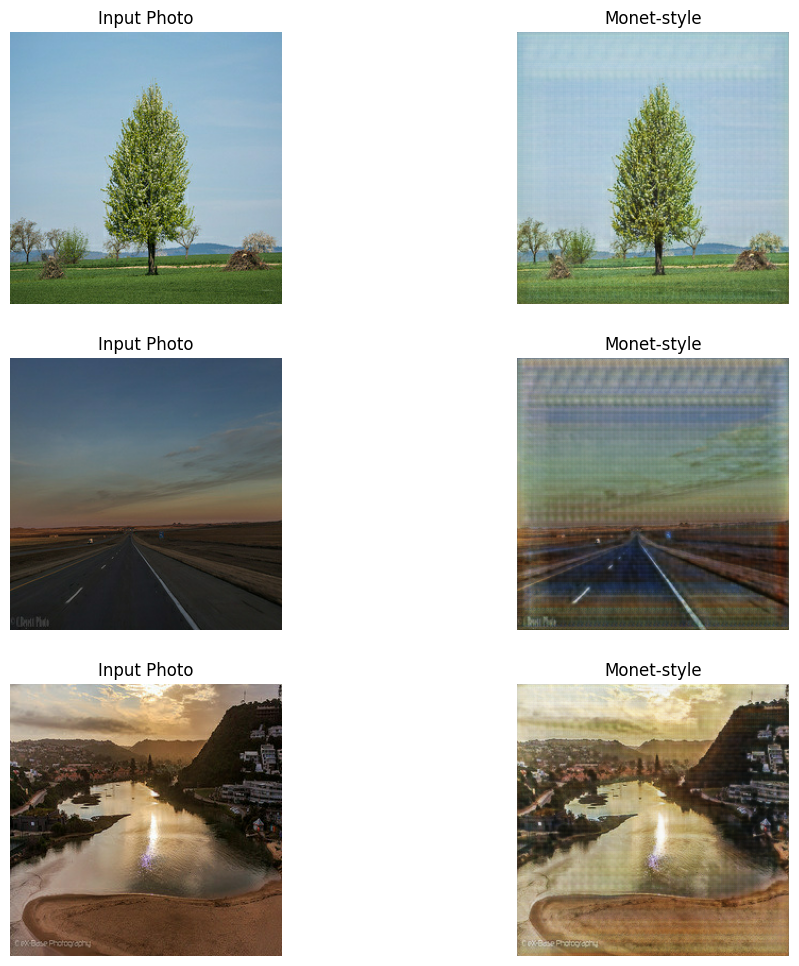

In [24]:
_, ax = plt.subplots(3, 2, figsize=(12, 12))
for i, img in enumerate(photo_set.take(3)):
    prediction = Monet_gen(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-style")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

We can see that 15 epochs did in fact transform these photos even more than 5 epochs did. Let's see what happens when we double the number of epochs to 30,

In [25]:
hist3 = cycle_gan_model.fit(tf.data.Dataset.zip((Monet_set, photo_set)),epochs=30)

Epoch 1/30
300/300 [==============================] - 131s 436ms/step - monet_gen_loss: 2.5899 - photo_gen_loss: 2.6812 - monet_disc_loss: 0.6361 - photo_disc_loss: 0.6221
Epoch 2/30
300/300 [==============================] - 133s 442ms/step - monet_gen_loss: 2.6448 - photo_gen_loss: 2.8235 - monet_disc_loss: 0.6299 - photo_disc_loss: 0.5902
Epoch 3/30
300/300 [==============================] - 133s 443ms/step - monet_gen_loss: 2.6198 - photo_gen_loss: 2.7656 - monet_disc_loss: 0.6374 - photo_disc_loss: 0.5978
Epoch 4/30
300/300 [==============================] - 133s 444ms/step - monet_gen_loss: 2.6712 - photo_gen_loss: 2.8375 - monet_disc_loss: 0.6353 - photo_disc_loss: 0.5916
Epoch 5/30
300/300 [==============================] - 133s 443ms/step - monet_gen_loss: 2.6600 - photo_gen_loss: 2.7899 - monet_disc_loss: 0.6108 - photo_disc_loss: 0.5955
Epoch 6/30
300/300 [==============================] - 133s 443ms/step - monet_gen_loss: 2.7248 - photo_gen_loss: 2.8549 - monet_disc_loss: 0

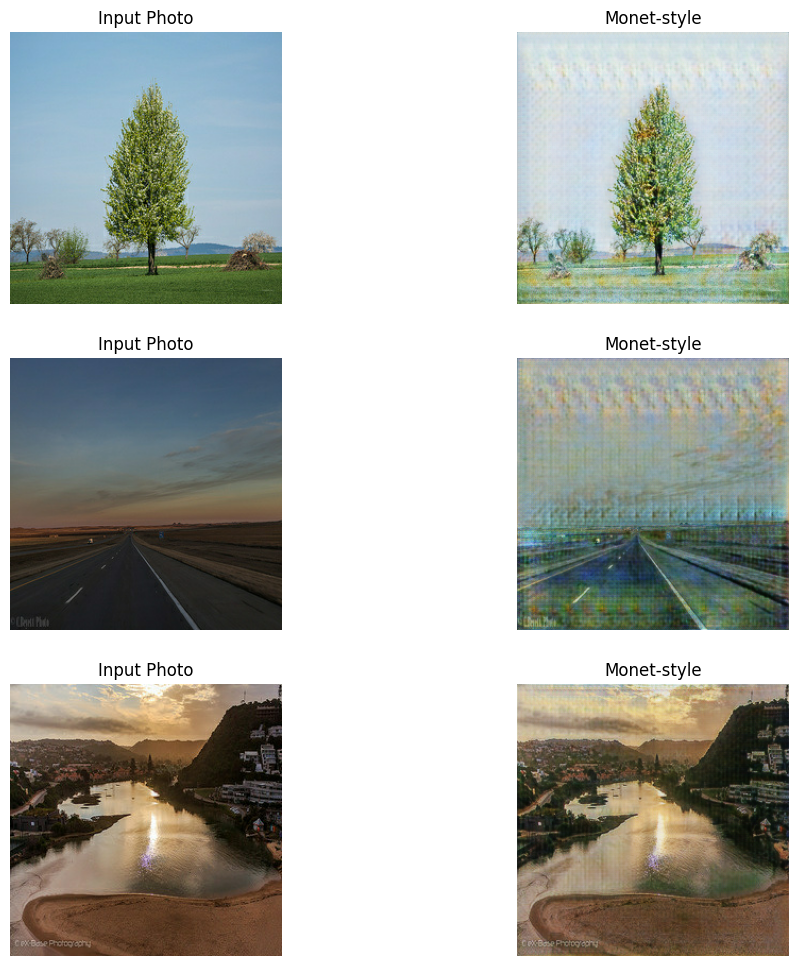

In [26]:
_, ax = plt.subplots(3, 2, figsize=(12, 12))
for i, img in enumerate(photo_set.take(3)):
    prediction = Monet_gen(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-style")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

There is a noticable difference in the change between our sample photos and the Monet-style creations the CycleGAN created. There even appears to be an overfitting happening in some cases. Perhaps there is a threshold where the number of epochs becomes determental to the learning process. Let's compare the loss function values for each model,

In [31]:
print(tabulate([['5 Epochs', 2.768, 2.7579, 0.6261, 0.6356],
                ['15 Epochs', 2.6212, 2.7491, 0.638, 0.6074],
                ['30 Epochs', 2.6766, 2.9727, 0.6305, 0.5714]],
               headers=['Number of Epochs', 'Monet Generator Loss', 'Photo Generator Loss', 'Monet Discriminator Loss', 'Photo Discriminator Loss']))

Number of Epochs      Monet Generator Loss    Photo Generator Loss    Monet Discriminator Loss    Photo Discriminator Loss
------------------  ----------------------  ----------------------  --------------------------  --------------------------
5 Epochs                            2.768                   2.7579                      0.6261                      0.6356
15 Epochs                           2.6212                  2.7491                      0.638                       0.6074
30 Epochs                           2.6766                  2.9727                      0.6305                      0.5714


As we increase the number of epochs, the discriminator continues to improve; however, somewhere between 15 and 30 epochs, the generator started overfitting this data.

## 5 Conclusion

As we saw in this project, a GAN model gets better with time, up to a certain point. The discriminator continued to improve as we increased the number of epochs from 5 to 30, but the generator started to overfit the data. In a future project, I would code in a stopping threshold for the generator to find the ideal model.

There are so many GAN models out there right now. I chose to use CycleGAN for this project because it's been used in other similar projects, including transforming photographs into paintings reminiscent of famous artists' work. In future work, I would explore using another GAN model, like WGAN since Keras has developed that methods for it.

I think during future work with CycleGan, I would try a different optimizer. All of the Keras examples that I read used Adam instead of RMSprop, so I would make a change to that gradient descent optimizer in an effort to improve the model.

## 6 Creating a Kaggle Submission csv

In [32]:
import PIL
! mkdir ../images

In [33]:
i = 1
for img in photo_set:
    prediction = Monet_gen(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

In [34]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'

## 7 Works Cited

$^{1}$ "I'm Something of a Painter Myself. Use GANs to create art - will you be the next Monet" Kaggle. https://www.kaggle.com/competitions/gan-getting-started/overview

$^{2}$ Keras. https://keras.io

$^{3}$ Holbrook, Ryan. "TFRecords Basics." Kaggle. https://www.kaggle.com/code/ryanholbrook/tfrecords-basics

$^{4}$ Youssef, Abdou. "Image Downsampling and Upsampling Methods," Dept of EECS, George Washington University, Washington DC.

$^{5}$ Jang, Amy. "Monet CycleGAN Tutorial." Kaggle. https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook

$^{6}$ Hui, Johnathan. "GAN - What is Generative Adversarial Networks GAN?" Medium. 19 Jun, 2018, https://jonathan-hui.medium.com/gan-whats-generative-adversarial-networks-and-its-application-f39ed278ef09

$^{7}$ Brownlee, Jason. "A Gentle Introduction to CycleGAN for Image Translation." Machine Learning Mastery. 17 Aug, 2019, https://machinelearningmastery.com/what-is-cyclegan/

$^{8}$ Zhu, Jun-Yan. "CycleGAN." Github. https://github.com/junyanz/CycleGAN

$^{9}$ Chollet, Francois. "Building Autoencoders in Keras." Keras. 14 May, 2016, https://blog.keras.io/building-autoencoders-in-keras.html


## 8 Link for GitHub Repository

https://github.com/minesalum/msds-5511-GAN.git